In [1]:
import numpy as np
import pandas as pd
import scipy
from numpy import linalg as LA
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle
from sklearn.datasets import fetch_mldata
import sklearn.preprocessing
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC as ls
%matplotlib inline

# hw2 - External file
Because ```fetch_mldata``` is not working on Shuki's machine

In [2]:
mnist = fetch_mldata('MNIST original')
data = mnist['data']
labels = mnist['target']

neg, pos = 0,8
train_idx = np.random.RandomState(0).permutation(where((labels[:60000] == neg) | (labels[:60000] == pos))[0])
test_idx = np.random.RandomState(0).permutation(where((labels[60000:] == neg) | (labels[60000:] == pos))[0])

train_data_unscaled = data[train_idx[:6000], :].astype(float)
train_labels = (labels[train_idx[:6000]] == pos)*2-1

validation_data_unscaled = data[train_idx[6000:], :].astype(float)
validation_labels = (labels[train_idx[6000:]] == pos)*2-1

test_data_unscaled = data[60000+test_idx, :].astype(float)
test_labels = (labels[60000+test_idx] == pos)*2-1

# Preprocessing
train_data = sklearn.preprocessing.scale(train_data_unscaled, axis=0, with_std=False)
validation_data = sklearn.preprocessing.scale(validation_data_unscaled, axis=0, with_std=False)
test_data = sklearn.preprocessing.scale(test_data_unscaled, axis=0, with_std=False)

In [3]:
train_data.shape, validation_data.shape, test_data.shape

((6000L, 784L), (5774L, 784L), (1954L, 784L))

In [5]:
np.unique(test_labels)

array([-1,  1])

## Perceptron algorithm

In [5]:
def perceptron(samples,samples_labels):
    errors=0
    w = np.zeros(samples.shape[1]) # initialize w to zeros
    for i in range(0,len(samples)):
        pred = np.sign(w.dot(samples[i].T)) == samples_labels[i] # marks a correct or incorrect prediction
        if not pred: # mistake happened, need to update w
            w+= samples[i]*samples_labels[i]
            errors+=1
        
    return w

### Q1 (a) Perceptron with different n values

In [7]:
def q1_a_perc_for_n(train_data, train_labels, test_data, test_labels, T=100):
    n_set = [5,10,50,100,500,1000,5000]
    # normalize the train and test data
    train_data, test_data = normalize(train_data), normalize(test_data)
    errors = {}
    for n in n_set:
        n_train, n_train_labels = train_data[:n,], train_labels[:n]
        errors[n] ={}
        for t in xrange(T):
            # reshuffle train sets
            nt_train, nt_train_labels = shuffle(n_train, n_train_labels)
            new_w = perceptron(nt_train, nt_train_labels)
            # calculate the test error
            test_current_err = 0
            for t_index in range(0, len(test_data)):
                if np.sign(new_w.dot(test_data[t_index].T)) != test_labels[t_index]: # add error when prediction is not equal to real label
                    test_current_err += 1
            errors[n][t] = 1.0-test_current_err*1.0/len(test_data)
    return errors

In [8]:
errors= q1_a_perc_for_n(train_data, train_labels, test_data,test_labels)

In [9]:
pd.DataFrame(errors).apply(lambda r: pd.Series({'mean': r.mean(), 'per05': r.quantile(q=0.05),'per95':r.quantile(q=0.95)})).transpose()

,mean,per05,per95
5,0.796612,0.405834,0.904299
10,0.841325,0.587743,0.968782
50,0.927354,0.835056,0.975435
100,0.947584,0.877149,0.981781
500,0.980553,0.970778,0.988229
1000,0.984498,0.969806,0.991300
5000,0.987692,0.978454,0.992323


### Q1 (b) Perceptron on all training data

In [10]:
def q1_b_perc_all_training(train_data,train_labels, train_data_unscaled):
    global_w = perceptron(train_data,train_labels)
    fig = plt.figure()
    plot = plt.imshow(reshape(global_w  -train_data_unscaled.mean(axis=0),(28,28)), interpolation='nearest')
    fig.colorbar(plot)
    return global_w

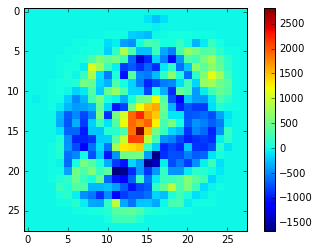

In [11]:
global_w = q1_b_perc_all_training(train_data,train_labels, train_data_unscaled)

The color in the above photo indicates high weight in the respective pixel. In other words, the colored zones, especially in the center, are the pixeles which have the most effect on our classifier between zero and eight digits. This makes sense since the center of the photo exists onlt for 'eight' digits but not for 'zeros', which is a good rule for classifying between them.

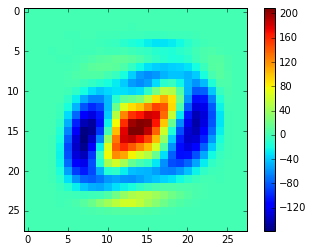

In [12]:
fig = plt.figure()
plot = plt.imshow(reshape(train_data_unscaled[train_labels == 1].mean(axis=0) - train_data_unscaled[train_labels != 1].mean(axis=0),(28,28)), interpolation='nearest')
fig.colorbar(plot)

### Q1 (c) classifier on the test set

In [49]:
def q1_c_perc_on_test_set(w, test_data, test_labels, ques='q1_c'):
    errors = 0
    for t in range(0,len(test_data)):
        if np.sign(w.dot(test_data[t].T)) != test_labels[t]: # add error when prediction is not equal to real label
                errors += 1
    print ques+'Accuracy on entire test data is ', round(1-errors*1.0/len(test_data),2)
    return 1-errors*1.0/len(test_data)

In [14]:
q1_c_perc_on_test_set(global_w, test_data, test_labels)

Accuracy on entire test data is  0.99


0.9897645854657113

### Q1 (d) show misclassified

In [15]:
def q1_d_perc_test_mistake(w, test_data, test_labels):
    for t in range(0,len(test_data)):
        if np.sign(w.dot(test_data[t].T)) != test_labels[t]: # add error when prediction is not equal to real label
                plt.imshow(reshape(test_data_unscaled[t],(28,28)), interpolation='nearest')
                print 'The digit is classified as ', np.sign(w.dot(test_data[t].T)), ' but it is actually', test_labels[t]
                return test_data[t], np.sign(w.dot(test_data[t].T)), test_labels[t]

The digit is classified as  -1.0  but it is actually 1


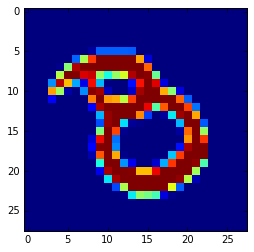

In [16]:
img = q1_d_perc_test_mistake(global_w, test_data, test_labels)

This digit is labeled in the test set as eight, but our classifier labeled it as zero. At first look, it is hard to tell what digit is it. A possible explanation would be the big circle in the center, which seemed to our classifier as zero and as we saw in (b) the weights that indicates the eight digits the most are located in the center of the photo.

## SVM

In [17]:
def q2_a_SVM_C(train_data, train_labels, validation_data,validation_labels):
    C_range = np.power(10.0,-1.0*np.arange(-10,10,1))
    pred_validation, pred_training = [], []
    for c in C_range:
        clf = ls(loss='hinge', C = c, fit_intercept=False)
        clf.fit(train_data,train_labels)
        pred_validation.append(clf.score(validation_data, validation_labels))
        pred_training.append(clf.score(train_data, train_labels))
    return C_range, pred_training, pred_validation

In [18]:
def q2_a_plot(C_range, pred_validation, pred_training):
    plt.figure()
    plt.plot(np.log10(C_range), pred_validation)
    plt.plot(np.log10(C_range), pred_training)
    plt.xlabel('C values by exponent (base 10)')
    plt.ylabel('accuracy')
    plt.title('Training and Validation Accuracy as a function of C')
    plt.ylim([min(pred_validation),1.02])
    plt.legend(['Validation Accuracy','Training Accuracy'])

In [19]:
C_range, pred_training, pred_validation = q2_a_SVM_C(train_data, train_labels, validation_data,validation_labels)

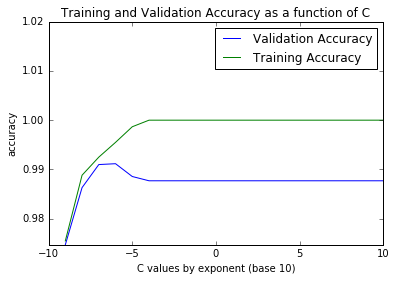

In [20]:
q2_a_plot(C_range, pred_validation, pred_training)

## 2(b) 
High C value leads to more complex model (overfitted) that fits better to train, but less on validation. 10^(-7) is the best point for accuracy on validation since it keeps the generalisation of the model, but allows minimal errors.

## 2(c) best C

In [26]:
def q2_c_best_w(C_range,train_data, train_labels, pred_validation):
    best_c = C_range[pred_validation.index(max(pred_validation))]
    clf = ls(loss='hinge', C = best_c, fit_intercept=False)
    clf.fit(train_data,train_labels)
    best_w = clf.coef_
    plt.figure()
    plt.imshow(reshape(best_w,(28,28)), interpolation='nearest')
    return clf

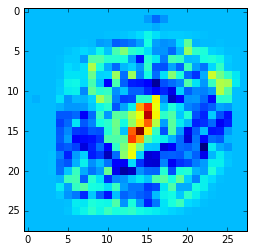

In [27]:
clf = q2_c_best_w(C_range,train_data, train_labels, pred_validation)

We got a very similar image for the weights to the one we recieved on the perceptron.

## 2(d) acc on test set

In [28]:
def q2_d(clf, test_data, test_labels):
    '''Q2 (d) given the SVM obj and test data and labels, prints and returns the score on the test data'''
    score =  clf.score(test_data, test_labels)
    print 'q2_d: Test error using the best C is :', score
    return score

q2_d(clf, test_data, test_labels)

q2_d: Test error using the best C is : 0.994370522006


0.99437052200614129

## SGD

In [29]:
def SVM_SGD(train_data, train_labels, C, eta0, T=1000):
    errors=0
    w = np.zeros(train_data.shape[1]) # initialize w to zeros
    for i in range(T):
        rand_index = np.random.choice(np.arange(len(train_labels))) # random choose index for the iteration
        
        if train_labels[rand_index]*w.dot(train_data[rand_index].T) < 1: # mistake happened, need to update w
            eta1 = eta0/(i+1) # calculate eta_t
            w = (1-eta1)*w+eta1*C*train_labels[rand_index]*train_data[rand_index] # update w
            errors+=1
        
    return w

## Q3 (a) SGD_SVM on several eta values

In [30]:
def q3_a_SGD_SVM_eta(train_data, train_labels, validation_data, validation_labels, K=10):
    eta_range = np.power(10.0,-1.0*np.arange(0,10,1)) # eta range of possible values
    accuracy= [] # accuracy list, hold per eta the accuracy
    for eta in eta_range:
        k_error =[]
        for k in range(K):
            w = SVM_SGD(train_data, train_labels, C=1, eta0=eta, T=1000) # train SGD_SVM on all training set
            k_err =0
            for t in range(len(validation_data)): # iterate over all validation set
                if validation_labels[t]*np.sign(w.dot(validation_data[t].T)) <1: # in case prediction is not consistent with the label
                    k_err +=1
            k_error.append(1.0*k_err/len(validation_data))
        accuracy.append(1-1.0*sum(k_error)/K)
    return eta_range, accuracy

In [31]:
def q3_a_plot(eta_range, accuracy):
    plt.plot(log10(eta_range), accuracy)
    plt.xlabel('eta exponent (base 10) values')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy as a function of eta')
    plt.legend(['Validation Accuracy'], loc=3)

In [32]:
eta_range, accuracy = q3_a_SGD_SVM_eta(train_data, train_labels, validation_data, validation_labels)

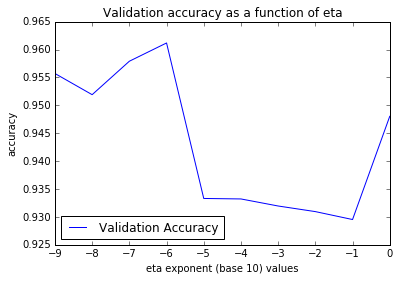

In [33]:
q3_a_plot(eta_range, accuracy)

In [34]:
eta_best = list(eta_range)[(accuracy.index(max(accuracy)))]
print 'eta_best is ', eta_best

eta_best is  1e-06


Eta possible values we chose was exponential range of -9 to 0 base 10. This makes sense because eta is being updated 1/t.  
Best value is reached at $\eta_0=10^{-6}$  


## Q3 (b) SGD on various C

In [35]:
def q3_b_SGD_SVM_C(validation_data, validation_labels, eta_best ,C_range, K=10):
    
    accuracy= [] # accuracy list, hold per eta the accuracy
    for c in C_range:
        k_error =[]
        for k in range(K):
            w = SVM_SGD(train_data, train_labels, C=c, eta0=eta_best, T=1000) # train SGD_SVM on all training set
            k_err =0
            for t in range(len(validation_data)): # iterate over all validation set 
                if validation_labels[t]*np.sign(w.dot(validation_data[t].T)) <1: # in case prediction is not consistent with the label
                    k_err +=1
            k_error.append(1.0*k_err/len(validation_data))
        accuracy.append(1-1.0*sum(k_error)/K)
    return C_range, accuracy

In [36]:
def q3_b_plot(C_range, accuracy):
    plt.plot(np.log10(C_range), accuracy)    
    plt.xlabel('C values by exponent (base 10)')
    plt.ylabel('accuracy')
    plt.title('Validation Accuracy as a function of C')
#     plt.ylim([0.9,1.01])
    plt.legend(['Validation Accuracy'], loc=3)

In [41]:
C_range = np.power(10.0,-1.0*np.arange(-20,20,1))

In [42]:
c_range, acc = q3_b_SGD_SVM_C(validation_data, validation_labels, eta_best, C_range = C_range)

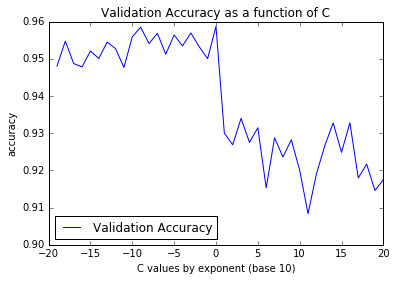

In [43]:
q3_b_plot(c_range, acc)

In [44]:
C_best = round(list(c_range)[(acc.index(max(acc)))],2)

## Q3 (c) Best C and eta

In [46]:
def q3_c_best_c_eta(c_range, acc, train_data, train_labels, eta_best):
    C_best = round(list(c_range)[(acc.index(max(acc)))],2)
    w = SVM_SGD(train_data, train_labels, C_best, eta_best, T=20000)
    plt.imshow(reshape(w,(28,28)), interpolation='nearest')
    return w

## Q3 (d) accuracy on the test set

q3_dAccuracy on entire test data is  0.99


0.9866939611054247

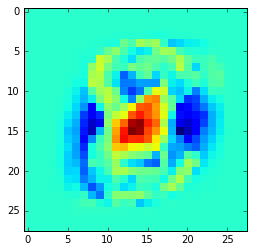

In [50]:
w_best = q3_c_best_c_eta(c_range, acc, train_data, train_labels, eta_best)
q1_c_perc_on_test_set(w_best, test_data, test_labels , ques = 'q3_d')

q3_dAccuracy on entire test data is  0.97


0.9687819856704196

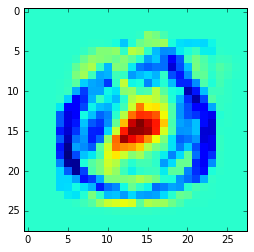

In [53]:
w_best = q3_c_best_c_eta(c_range, acc, train_data, train_labels, eta_best)
q1_c_perc_on_test_set(w_best, test_data, test_labels , ques = 'q3_d')

## Bonus

In [ ]:
import sklearn.svm as svm

In [ ]:
kernels = ['rbf']#,'poly2','poly3','poly4','poly5','poly6','rbf','sigmoid']
C_range = np.power(10.0,-1.0*np.arange(-50,51,10))

In [ ]:
C_range

In [ ]:
res = []
for K in kernels:
    for C in C_range:
        if K[:4]=='poly':
            clf = svm.SVC(kernel='poly', C=C, degree=int(K[-1]),shrinking=True)
        else:
            clf = svm.SVC(kernel=K, C=C,shrinking = True)
        clf.fit(train_data, train_labels) 
        preds= clf.predict(validation_data)
        score = sum(preds== validation_labels)*1.0/len(validation_labels)
        print K,C,score
        res.append([K,C,score])
d = pd.DataFrame(res, columns=['Kernel','C','Accuracy'])


d.to_csv('CVres5.csv')

## Best Model: Poly4 - 0.997 on validation set

In [34]:
res

[['poly1', 10.0, 0.98856944925528234],
 ['poly1', 1.0, 0.98856944925528234],
 ['poly1', 0.10000000000000001, 0.98856944925528234],
 ['poly2', 10.0, 0.99636300658122623],
 ['poly2', 1.0, 0.99636300658122623],
 ['poly2', 0.10000000000000001, 0.99636300658122623],
 ['poly3', 10.0, 0.99688257706962247],
 ['poly3', 1.0, 0.99688257706962247],
 ['poly3', 0.10000000000000001, 0.99688257706962247],
 ['poly4', 10.0, 0.99722895739521999],
 ['poly4', 1.0, 0.99722895739521999],
 ['poly4', 0.10000000000000001, 0.99722895739521999],
 ['poly5', 10.0, 0.99636300658122623],
 ['poly5', 1.0, 0.99636300658122623],
 ['poly5', 0.10000000000000001, 0.99636300658122623],
 ['rbf', 10.0, 0.50138552130239],
 ['rbf', 1.0, 0.50138552130239],
 ['rbf', 0.10000000000000001, 0.50138552130239],
 ['sigmoid', 10.0, 0.50138552130239],
 ['sigmoid', 1.0, 0.50138552130239],
 ['sigmoid', 0.10000000000000001, 0.50138552130239]]

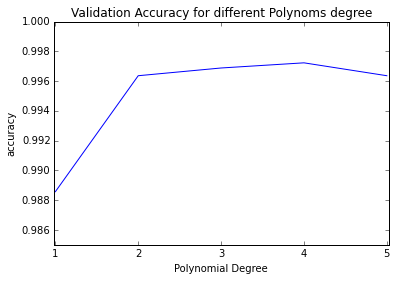

In [43]:
degree , accuracy = map(lambda x: (x[0][-1]),res[0:15:3]), map(lambda x: x[2], res[0:15:3])
plt.plot(degree,accuracy)    
plt.xlabel('Polynomial Degree')
plt.ylabel('accuracy')
plt.title('Validation Accuracy for different Polynoms degree')
p = plt.ylim([0.985,1.0])
p = plt.xlim([0.98,5.02])

Poly is a great classifier not because of the circular shape (we have 784 dimentions and not 2) but thanks to the Moments theory in **pattern recognition:**
- 1st moment of pixels = linear combination ~ Area of the shape
- 2nd moment of pixels = quadratic combination ~ deviance from the center
- 3rd moment ~ skewness etc.
<br>
This way, our classifier in less sensitive to disposition/rotation/flipping/resizing of the shape.
Sigmoid/RBF were more weak, since they expected a specific value on each pixel, and built threshold boudaries around it - while the image is not dependant on pixel values, but on their combinations.

In [44]:
clf = svm.SVC(kernel='poly', C=1, degree = 4)
clf.fit(train_data, train_labels) 
preds= clf.predict(test_data)
score = sum(preds== test_labels)*1.0/len(test_labels)
print 'Performance on Test set:',round(score,3)

Performance on Test set: 0.995
